# Projet RO - Optimisation Hivernale
## **1.Présentation de l'énoncé**
Dans ce projet, nous allons comprendre comment optimiser le déneigement de la ville de Montréal.

Cette démonstration comporte 3 parties:
* Analyse du problème
* Parcours du Drone
    * Théorie
    * Pratique
* Parcours de la Déneigeuse
    * Théorie
    * Pratique
* Modèle de Coût
* Conclusion

Nous allons commencer par définir le vocabulaire que nous utiliserons dans ce notebook :

* Un node : un nœud du graphe
* Un edge : l’axe qui relie deux node entre eux

En première partie nous allons nous occuper du trajet du drone. Pour cela nous considérons donc un graphe non orienté car le drone n’a pas besoin de suivre le sens de la circulation (et que c’est plus simple !). Nous sommes partis du principe que notre graphe est connexe. En effet, si toutes les rues d’une ville ne sont pas reliées ce n’est pas une ville… Nous parcourons donc le graphe avec le drone. Nous envoyons un drone survoler les rues pour savoir combien de centimètres de neige il y a sur chaque rue. Cela va nous servir pour définir les rues prioritaires au déneigement.

Pour inventer les valeurs de taux de neige sur chaque rue, on applique une courbe Gaussienne avec 3.189 d'écart type et 8.75 de moyenne. Cela nous permet d'avoir une chance de 95% d'avoir de la neige. Ensuite, le drone éliminera automatiquement les rues qui ont un taux de neige inférieur à 2.5cm et supérieur à 15cm.



Une fois que le parcours du graphe par le drone est acté, nous pouvons passer au parcours de la déneigeuse. Celle-ci doit en revanche suivre les sens de circulation, nous allons donc avoir besoin d’un graphe orienté. Nous allons, à partir d’ici, utiliser la bibliothèque OSMNX qui nous permet de transformer n’importe quel plan de ville en graphe orienté grâce à la méthode graph_from_place(). Nous devons ajouter le paramètre « drive » car la vitesse de déplacement de la déneigeuse se rapproche plus de celle d’une voiture que de celle d’un passant. 


...

...

...



![alt text](images/balances_euler.png)

Ensuite, pour rendre tout cela plus visuel et plus attractif, on va afficher le graphe à l’écran à l’aide de la fonction plot_graph. Sur cet exemple, la ville est petite et on a donc besoin de ne faire qu’une seule requête au système afin d’afficher et d’utiliser le graphe. En revanche, pour Montréal, nous devrons faire une dizaine de requêtes de part la taille de la ville (une par qartier en fait). Il faudra néanmoins faire attention car si on lance plusieurs requêtes en moins d’une seconde, on est "banni" du système pendant 60 secondes.

![alt text](images/stras_maps.png "Strasbourg vue aérienne")

## **2 Architecture du Projet**
Nous avons regroupé la plupart du code dans deux différentes parties comme préconisé par le sujet :
* **theoric** : les fonctions d'affichage, de calcul et de sauvegarde d'images matplotlib
* **practical** : la classe Graph, les fonctions utilitaires de Graph et tests

Il existe à l'extérieur de ces dossiers des programmes de tests **example_*.py**

[image de la hiérarchie en mode (Visual Studio Code)]

## **3.Partie Théorique**
Maintenant, prenons des cas de graphes simples... [explication de pk la théorie]

En premier lieu pour développer, nous avons besoin d'importer certaines librairies.
Elles sont :
* *theoric* : notre librarie de gestion théorique de graphes, contient les fonctions qui altèrent un objet de classe Graph
* *practical* : notre librarie de gestion pratique de graphes, contient les fonctions d'affichage, de calcul, et de sauvegarde
* *matplotlib.pyplot* : librarie pour dessiner des graphs genérés par NetworkX
* *osmnx* : librarie qui permet d'avoir des données geospatiales de parties du globe, elle contient NetworkX, qui gère les graphes

### 3.A Graphe Non-Orienté (Parcours du Drone)

#### 3.A.I Code
[explications ? du truc + des imports]

Try counter: 1 (nodes_number: 8, edges_number: 11)


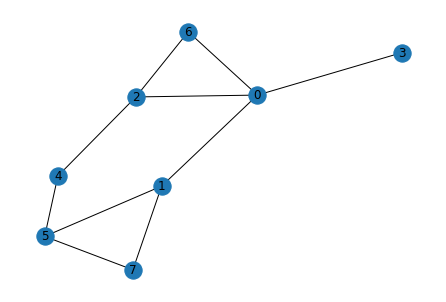

In [1]:
# code d'un graph non-orienté test
# + photos normal, eulérisé, cycle eulérien printé + plotté

from theoric.eulerize_directed import eulerize_directed
from theoric.utils import *
from theoric.utils_euler import find_eulerian_cycle_directed

nodes_number = 8

edges_directed, edges_undirected = random_connected_graph(nodes_number)

graph_undirected = Graph(nodes_number, edges_undirected, False)

nxgraph_undirected = undirected_graph_to_nxgraph(graph_undirected)

show_nxgraph(nxgraph_undirected)

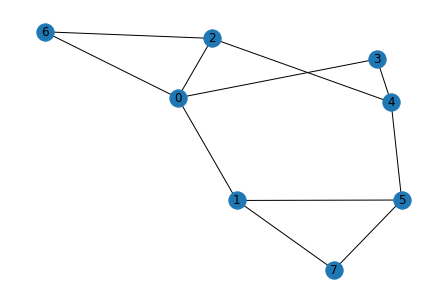

In [2]:
edges_undirected_eulerized = eulerize_undirected(nodes_number, graph_undirected.edges)

graph_undirected_eulerized = Graph(nodes_number, edges_undirected_eulerized)

nxgraph_undirected_eulerized = undirected_graph_to_nxgraph(graph_undirected_eulerized)

show_nxgraph(nxgraph_undirected_eulerized)

eulerian_cycle_undirected:  [0, 1, 5, 1, 7, 5, 4, 2, 0, 3, 4, 2, 6]


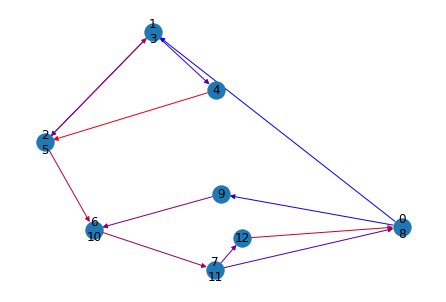

In [3]:
eulerian_cycle_undirected = find_eulerian_cycle_undirected(nodes_number, graph_undirected_eulerized.edges, 0)

print ("eulerian_cycle_undirected: ", eulerian_cycle_undirected)

show_cycle(nodes_number, eulerian_cycle_undirected)

***Quand tu importes un truc il faut faire ça : (exemple)***

En premier lieu pour développer, nous avons besoin d'importer certaines librairies.
Elles sont :
* *theoric* : notre librarie de gestion théorique de graphes, contient les fonctions qui altèrent un objet de classe Graph
* *practical* : notre librarie de gestion pratique de graphes, contient les fonctions d'affichage, de calcul, et de sauvegarde
* *matplotlib.pyplot* : librarie pour dessiner des graphs genérés par NetworkX
* *osmnx* : librarie qui permet d'avoir des données geospatiales de parties du globe, elle contient NetworkX, qui gère les graphes

#### 3.A.II Tests de Performances
[explications ?]

In [4]:
# code des tests du graph non-orienté test ou photos

### 3.B Graphe Orienté (Parcours d'une déneigeuse)

#### 3.B.I Code
[explications ?]

Try counter: 1 (nodes_number: 8, edges_number: 12)


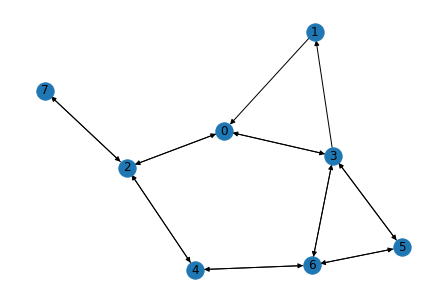

In [5]:
# code d'un graph orienté test
# + photos normal, eulérisé, cycle eulérien printé + plotté

from theoric.eulerize_directed import eulerize_directed
from theoric.utils import *
from theoric.utils_euler import find_eulerian_cycle_directed

nodes_number = 8

edges_directed, edges_undirected = random_connected_graph(nodes_number)

graph_directed = Graph(nodes_number, edges_directed)

nxgraph_directed = directed_graph_to_nxgraph(graph_directed)

show_nxgraph(nxgraph_directed)

Successfully ? True


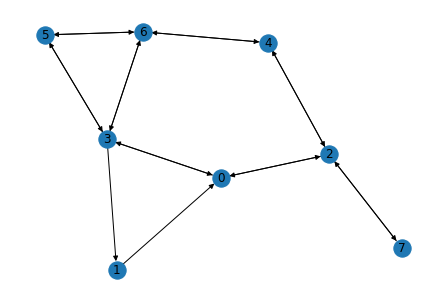

In [6]:
edges_directed_eulerized = eulerize_directed(nodes_number, graph_directed.edges)

graph_directed_eulerized = Graph(nodes_number, edges_directed_eulerized)

print ("Successfully ?", graph_directed_eulerized.is_eulerian())

nxgraph_directed_eulerized = directed_graph_to_nxgraph(graph_directed_eulerized)

show_nxgraph(nxgraph_directed_eulerized)

eulerian_cycle_directed:  [0, 3, 6, 5, 6, 4, 6, 3, 5, 3, 1, 0, 3, 0, 2, 7, 2, 4, 2]


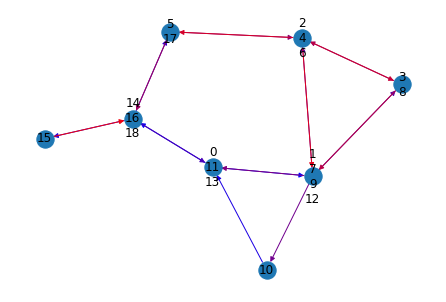

In [7]:
eulerian_cycle_directed = find_eulerian_cycle_directed(nodes_number, graph_directed_eulerized.edges, 0)

print ("eulerian_cycle_directed: ", eulerian_cycle_directed)

show_cycle(nodes_number, eulerian_cycle_directed)

#### 3.B.II Tests de Performances
[explications ?]

In [8]:
# code des tests du graph orienté test ou photos

## **4 Partie Pratique**
Maintenant, prenons des cas concrets... [explication de pk la pratique tkt]

### 4.A Diviser Pour Régner
En fait on divise Montréal en petites parties (tkt) [explique stp]
\+ photos de plrs découpages

### 4.B Exemple d'un Quartier
Ouais on prend Anjou pour essayer [car tkt]

Processing Anjou (undirected)


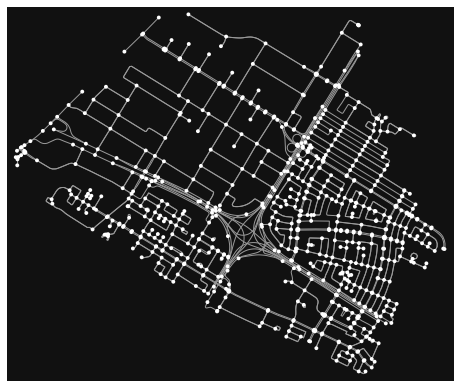

<Figure size 432x288 with 0 Axes>

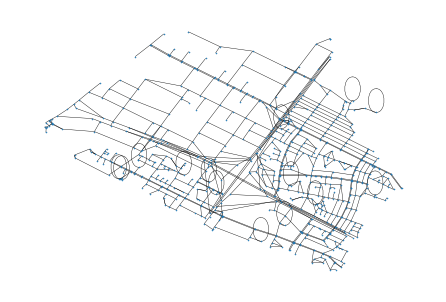

edges : 1115  nodes : 728  and fraction is : 1.5315934065934067
Adding snow


<Figure size 432x288 with 0 Axes>

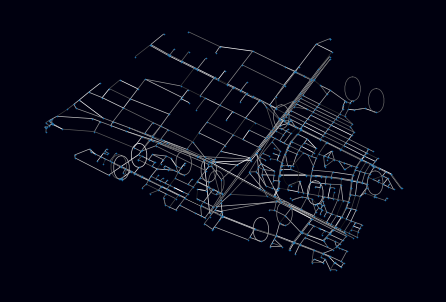

Removing unsnowy non bridges roads
Is the graph Eulerian: False / Edges count: 1115
Total street length 151.91km
Eulerized 1115 edges to 1366
Is the graph Eulerian: True / Edges count: 1366
Finding a cycle
Plotting the cycle


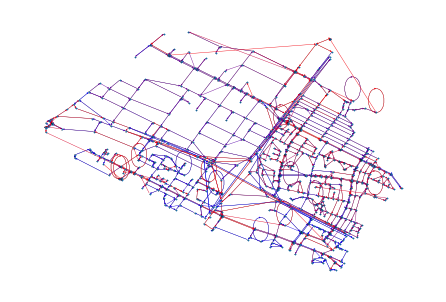

Processing Anjou (directed)


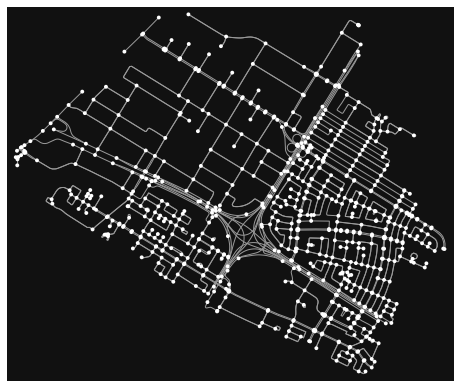

<Figure size 432x288 with 0 Axes>

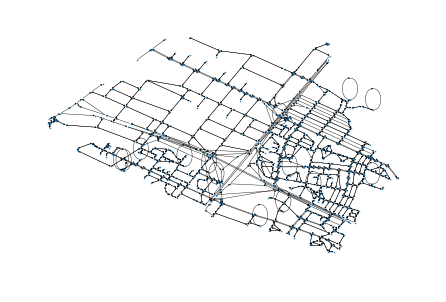

728 1690
Adding the snow and lenghts the drone saw


<Figure size 432x288 with 0 Axes>

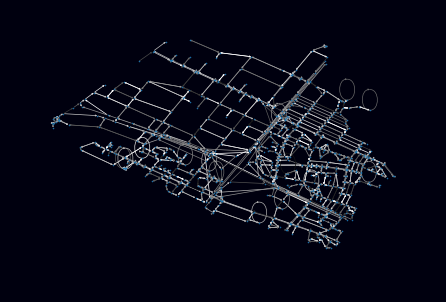

Is the graph Eulerian: False / Edges count: 1690
Eulerized 1690 edges to 1754
Is the graph Eulerian: True / Edges count: 1754
Finding a cycle
Plotting the cycle


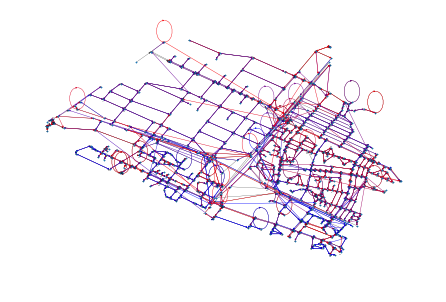

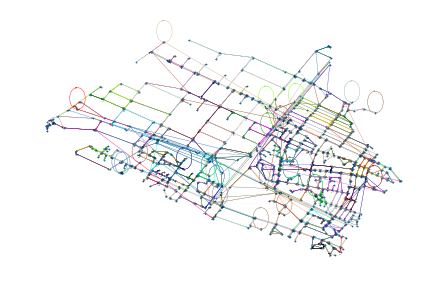

distance : 202.88km

snow : 920.19m3

fuel spent : 243.46L

fuel cost : 421.18$

time : 0:3:28$

plows : 140


In [9]:
# code de example for one pour Anjou

from practical.data import *
import matplotlib

data = getData("Anjou")

snow = process_undirected("Anjou", data, True)

name, totalweight, cycleData = process_directed("Anjou", data, snow, True)
snow_plows_count = 140 # example
process_directed_data(name, *cycleData, snow_plows_count, True)

On a utilisé process_undirected et process_directed et process_directed_data mais c'est quoi ?????? [explique stp en rappelant qu'on utilise la théorie]

#### 4.B.I Process Undirected
[explications ? drone]

In [10]:
# code de process undirected
# plot and process the data in a undirected way
def process_undirected(name, data, show=False):
    if not(os.path.isdir("imgs")):
        os.mkdir("imgs")
    if not(os.path.isdir("imgs/" + name)):
        os.mkdir("imgs/" + name)
    print("Processing " + name + " (undirected)")

    plot_data(name, data, show)

    # convert it to a nxgraph
    undirectedNxGraph = extract_undirected_graph(data)

    # get the points' positions
    position = get_position(undirectedNxGraph)

    # plot the nx graph
    plot_graph(name, "raw_undirected", undirectedNxGraph, position, show)

    # convert it to our graph class, keeping the old node IDs
    G, G_nodes = undirected_nxgraph_to_graph(undirectedNxGraph)
    
    print("edges :", len(G.edges), " nodes :", len(G_nodes), " and fraction is :", len(G.edges) / len(G_nodes))

    # snow height system

    print("Adding snow")
    G.add_random_snow() # according to a gaussian curve distribution of the snow height
    plot_snow(name, "undirected", G, undirectedNxGraph, position, show)
    print("Removing unsnowy non bridges roads")
    G.remove_unsnowy() # remove unsnowy and not "bridges" roads

    # end snow
    print("Is the graph Eulerian:", G.is_eulerian(), "/", "Edges count:", len(G.edges))
    # eulerize the graph

    weight = 0
    for edge in G.edges:
        weight += edge[2]
    print("Total street length", str(round(weight / 1000.0, 2)) + "km")
    G.eulerize()

    print("Is the graph Eulerian:", G.is_eulerian(), "/", "Edges count:", len(G.edges))

    # find an eulerian cycle in a directed graph
    print("Finding a cycle")
    cycle_undirected = find_eulerian_cycle_undirected(G.n, G.edges, 0)

    # convert the node list to a directed graph (cycle graph)
    G_cycle_undirected = directed_graph_from_cycle(G.n, cycle_undirected)

    print("Plotting the cycle")
    # plot the cycle graph
    plot_cycle(name, "undirected_cycle", undirectedNxGraph, cycle_undirected, G_cycle_undirected, G_nodes, show)

    # return the snow seen by the drone + street lengths
    return G.snow

#### 4.B.II Process Directed
[explications ? deneigeuse...]

In [11]:
# code de process directed
# plot and process the data in a directed way
def process_directed(name, data, snow, show=False):
    if not(os.path.isdir("imgs")):
        os.mkdir("imgs")
    if not(os.path.isdir("imgs/" + name)):
        os.mkdir("imgs/" + name)
    print("Processing " + name + " (directed)")
    
    plot_data(name, data, show)

    # convert it to a nxgraph
    directedNxGraph = extract_directed_graph(data)

    # get the points' positions
    position = get_position(directedNxGraph)

    # plot the nx graph
    plot_graph(name, "raw_directed", directedNxGraph, position, show)

    # convert it to our graph class, keeping the old node IDs
    G, G_nodes = directed_nxgraph_to_graph(directedNxGraph)

    l_1 = G.n
    l_2 = 0
    for edge in G.edges:
        l_2 += 1
    print(l_1, l_2)

    # snow height + weights system

    print("Adding the snow and lenghts the drone saw")
    G.add_snow_and_weights(G.edges, snow) # according to a gaussian curve distribution of the snow height
    plot_snow(name, "directed", G, directedNxGraph, position, show)

    # end snow
    print("Is the graph Eulerian:", G.is_eulerian(), "/", "Edges count:", len(G.edges))
    # eulerize the graph
    G.eulerize()

    print("Is the graph Eulerian:", G.is_eulerian(), "/", "Edges count:", len(G.edges))

    # find an eulerian cycle in a directed graph
    print("Finding a cycle")
    cycle_directed = find_eulerian_cycle_directed(G.n, G.edges, 0)

    # convert the node list to a directed graph (cycle graph)
    G_cycle_directed = directed_graph_from_cycle(G.n, cycle_directed)

    print("Plotting the cycle")
    # plot the cycle graph
    plot_cycle(name, "directed_cycle", directedNxGraph, cycle_directed, G_cycle_directed, G_nodes, show)
    total_distance_km = 0

    for i in range(1, len(cycle_directed)):
        a = cycle_directed[i - 1]
        b = cycle_directed[i]
        key = (a, b)
        n_key = find_key(snow, key)
        weight = 0
        if n_key != None:
            weight = n_key[2]
        total_distance_km += (weight / 1000)

    data = [
        directedNxGraph,
        cycle_directed,
        G_cycle_directed,
        G_nodes,
        G,
    ]

    return name, total_distance_km, data

#### 4.B.III Process Directed Data
[explications ? attendre toutes les tailles de quartiers comme ça on repartie les deneigeuses... bon ici y a que un quartier tkt, on part du principe que y a des cabanes à déneigeuses sinon c'est difficile]

In [12]:
# code de process directed data
def process_directed_data(name, directedNxGraph, cycle_directed, G_cycle_directed, G_nodes, G, snow_plow_per_district, show=False):
    plot_cycle_split(name, "directed_cycle_split", directedNxGraph, cycle_directed, G_cycle_directed, G_nodes, snow_plow_per_district, show)
    save_data(name, cycle_directed, G.snow, snow_plow_per_district, show)

#### 4.B.IV Save Data
[explications ? constantes...]

In [13]:
# save the calculated data in a file
def save_data(name, cycle, snow, plows, show=False):
    total_snow_volume = 0
    total_distance_km = 0

    # avg size of the roads
    avg_road_width = 5.0
    # avg fuel consumption per km in h for deneigeuses
    avg_fuel_consumption_per_h = 30.0
    # avg fuel cost in $
    avg_fuel_cost = 1.730
    # avg deneigeuse speed in km/h
    avg_speed = 25.0

    for i in range(1, len(cycle)):
        a = cycle[i - 1]
        b = cycle[i]
        key = (a, b)
        n_key = find_key(snow, key)
        weight = 0
        s = 0
        if n_key != None:
            weight = n_key[2]
            if n_key[0] != -1:
                s = snow[n_key]
        total_snow_volume += weight * (s / 100) * avg_road_width
        total_distance_km += (weight / 1000)

    total_snow_volume /= 100
    t = (total_distance_km / avg_speed)
    s = avg_fuel_consumption_per_h * t

    lines = [
        "distance : " + str(round(total_distance_km, 2)) + "km\n",
        "snow : " + str(round(total_snow_volume, 2)) + "m3\n",
        "fuel spent : " + str(round(s, 2)) + "L\n",
        "fuel cost : " + str(round(s * avg_fuel_cost, 2)) + "$\n",
        "time : " + hours_to_HMS(t / plows) + "$\n",
        "plows : " + str(plows)
        ]
    
    if not(show):
        with open("imgs/" + name + "/" + name + "_data.txt", 'w') as f:
            f.writelines(lines)
    else:
        for line in lines:
            print(line)

### 4.D Tous les quartiers
[explique que ici on prend en compte tout les quartiers]

In [14]:
from practical.data import *
from practical.districts import *

snow_plows = 2200

dataCollect = []

def subprocess(district):
    data = getData(district)

    snow = process_undirected(district, data)
    dataCollect.append(process_directed(district, data, snow))
"""
for dis in districts:
    subprocess(dis)

total = 0
for data in dataCollect:
    name, totalweight, cycleData = data
    total += totalweight

for data in dataCollect:
    name, totalweight, cycleData = data
    snow_plows_count = round((totalweight / total) * snow_plows)
    process_directed_data(name, *cycleData, snow_plows_count)

print("Finished")"""

'\nfor dis in districts:\n    subprocess(dis)\n\ntotal = 0\nfor data in dataCollect:\n    name, totalweight, cycleData = data\n    total += totalweight\n\nfor data in dataCollect:\n    name, totalweight, cycleData = data\n    snow_plows_count = round((totalweight / total) * snow_plows)\n    process_directed_data(name, *cycleData, snow_plows_count)\n\nprint("Finished")'

### 4.E Améliorations possibles
ouais dis que genre bah ça marche et mets des ptites photos des txts genre 1 ou 3 + 
mais que il serait possible de faire :
- save le graph en json -> le save avec un truc multithreadé
- save une image par déneigeuse par quartier
- save les osmnx data dans un fichier au lieu de faire une requête à chaque fois
- prendre en compte la taille de la route pour la répartition et la possibilité de couper une route en plusieurs morceaux si trop grande
- prendre en compte le temps que la déneigeuse arrive jusq'au point (sans cabane à deneigeuse)

## **5 Conclusion**
ouais bah ça marche tkt, en plus ça prend que 26h j'ai même le temps de mourir 2 fois

In [15]:
#################### TRUCS D'AVANT QUI POURRAIENT ÊTRE UTILISÉS #####################
############################# À ENLEVER SI PAS UTILISÉS #############################

Ce graphe n’est pas exploitable avec nos fonctions, qui elles sont compatibles avec la class Graph que nous avons construite, beaucoup plus simple et compréhensible. Nous devons donc transformer ce graphe et le rediriger vers une forme qui correspond aux attentes de nos fonctions. Cette action est possible grâce à la fonction directed_nxgraph_to_graph.

In [16]:
data = getData(district)

directedNxGraph = extract_directed_graph(data)

def directed_nxgraph_to_graph(nxGraph):
    graph = Graph(len(nxGraph), None, False)
    graph.edges = []
    
    nodes = {}
    index = 0
    for node in nxGraph.nodes:
        nodes[node] = index
        index += 1
    nodes

    length = nx.get_edge_attributes(nxGraph, "length")
    
    edges = []
    for edge in nxGraph.edges:
        node1 = nodes[edge[0]]
        node2 = nodes[edge[1]]
        weight = length[edge]
        edges.append((node1, node2, weight))
    
    graph.edges = edges
        
    return graph, nodes

G, G_nodes = directed_nxgraph_to_graph(directedNxGraph)

NameError: name 'district' is not defined

Sur cette version simplifiée, on applique les taux de neige que le drone a récupéré. 

On peut à présent afficher le graphe contenant la neige. Nous avons choisi d'afficher un trait plus épais et plus blanc pour une rue pleine de neige, et un trait plus fin et donc plus transparent pour une rue contenant une proportion moindre de neige.

In [ ]:
## ici plot snow

TypeError: object of type 'Graph' has no len()

A partir de ce graphe orienté enneigé, il va falloir trouver le cycle eulérien. Pourquoi ? Parce que cela permet de passer par toutes les routes du graphe d’un seul coup sans passer des points plusieurs fois, en somme ça nous permet d’optimiser notre solution. Comment ? Nous allons assigner une balance à chaque node. +1 pour chaque edge sortant -1 pour chaque edge entrant. Exemple avec ce graphe simple :

Pour un graphe orienté, il faut que toutes les balances soient nulles. On parcourt donc le graphe et à chaque balance non nulle, on ajoute des edges entrants ou sortants selon nos besoins. La fonction Distance de la librairie OSMNX nous permet d’ajouter la longueur des rues (ou des edges) en mètres sur le graphe. 

In [ ]:
![alt text](images/balances.png)

Afin d’avoir une idée du coût du déneigement total de Montréal, nous avons choisi de mesurer trois indicateurs : le temps + coût en carburant pour une seule déneigeuse, pour une déneigeuse pour 2 quartiers et enfin pour une déneigeuse par quartier.

cout1
cout2
cout3


On peut clairement voir que le coût est moindre lorsque l’on a une déneigeuse par quartier, ce qui paraît logique. La déneigeuse seule met beaucoup trop de temps et le Soleil irait bien plus vite pour faire disparaître toute cette neige. Enfin la troisième solution, une déneigeuse pour deux quartiers, est efficace mais un peu lente et certains quartiers pourraient se retrouver défavoriser par rapport à d’autres. Il faudrait alors déneiger de nuit, et nous ne sommes pas sûrs que les déneigeurs québécois acceptent ces dures conditions de travail.


Pour arriver à ce travail final, nous sommes passés par plusieurs étapes et plusieurs cul de sac... Voici un petit tableau récapitulatif des techniques que nous avons testées, des résultats que nous avons obtenus grâce à ces dernières mais surtout de leurs limites.

![alt text](images/tableau.png "Tableau récapitulatif de nos essais")